# SDRE

In [25]:
from pde import NeuralNet, LinearQuadraticRegulator2D, LinearQuadraticRegulator10D, LinearQuadraticRegulatorND, GenerateData, NonLinear, CuckerSmale
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import copy

In [26]:
# using gradV = Px

gradfx = lambda x, y: (x**4 + 1)**0.5 * (1 + 2*(x**2 + (x**4 + 1)**0.5))**0.5 * x + (x**2 + (x**4 + 1)**0.5) * y
gradfy = lambda x, y: (x**2 + (x**4 + 1)**0.5) * x + (1 + 2*(x**2 + (x**4 + 1)**0.5))**0.5 * y

In [27]:
# using exact derivative on gradV

p12 = lambda x: x**2 + np.sqrt(x**4 + 1)
p22 = lambda x: np.sqrt( 1 + 2*p12(x) ) 
p11 = lambda x: (np.sqrt(x**4 + 1)) * p22(x)

p12_deriv = lambda x: 2 * x * ( 1 + x**2 / np.sqrt(x**4 + 1) )
p22_deriv = lambda x: p12_deriv(x) / p22(x)
p11_deriv = lambda x: 2 * x**3 / np.sqrt(x**4 + 1) * p22(x) + np.sqrt(1 + x**4) * p22_deriv(x)

v1_deriv = lambda x, y: 0.5 * ( p11_deriv(x) * x**2 + 2 * x * p11(x) + 2*p12_deriv(x) * x * y + 2*p12(x) * y + y**2 * p22_deriv(x) )
v2_deriv = lambda x, y: p12(x) * x + p22(x) * y

In [28]:
import scipy.linalg
n_samples = 1
T = 10
dt = 0.1
barx = np.random.random( (n_samples, 2) )
barx = np.array([[0.8, 0.5], [0.3, -0.7]])

B = np.array([[0], [1]])
Q = np.eye(2, 2)
R = np.eye(2, 2)

def compute_trajectories():
    resu = {}
    save_u = {}
    for sample in range(n_samples):
        new_barx_i = barx[sample, :]
        save_barx_i = np.zeros( (100, 2) )
        save_u_i = np.zeros( (100, 1) )
        
        for i, t in enumerate( np.arange(0, T, dt) ):
            save_barx_i[i] = new_barx_i

            # compute the control
            barx_i = new_barx_i
            gradV = np.array( [gradfx(barx_i[0], barx_i[1]), gradfy(barx_i[0], barx_i[1])] )
            baru = - B.T @ gradV
            
            # compute the dynamics
            A = np.array([[0, 1], [barx_i[0]**2, 0]])
            new_barx_i = barx_i + A @ barx_i * dt + B @ baru * dt

            save_u_i[i] = baru.item()
            
        resu[sample] = save_barx_i
        save_u[sample] = save_u_i
    return resu, save_u

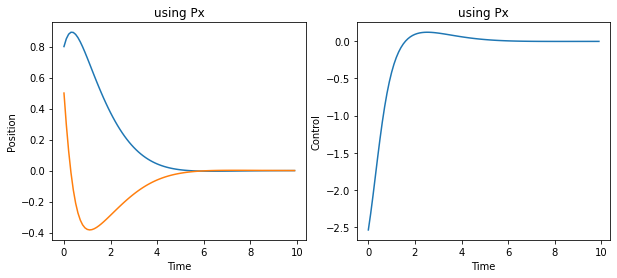

In [29]:
resu, save_u = compute_trajectories()

fig, axs = plt.subplots(1, 2,figsize=(10, 4))
ax = axs[0]
for sample in range(n_samples):
    ax.plot(np.arange(0, T, dt), resu[sample][:, 0])
    ax.plot(np.arange(0, T, dt), resu[sample][:, 1])
ax.set_ylabel('Position')
ax.set_xlabel('Time')
ax.set_title('using Px');

ax = axs[1]
for sample in range(n_samples):
    ax.plot(np.arange(0, T, dt), save_u[sample][:, 0])
ax.set_ylabel('Control')
ax.set_xlabel('Time')
ax.set_title('using Px');

In [135]:
def dataValueFunction( x ):
    stackedMatrices = np.zeros((x.shape[0], x.shape[1], x.shape[1]))

    p12 = lambda x: x**2 + np.sqrt(x**4 + 1)
    p22 = lambda x: np.sqrt( 1 + 2*p12(x) ) 
    p11 = lambda x: (np.sqrt(x**4 + 1)) * p22(x)

    stackedMatrices[:, 0, 0] = p11( x[:, 0] )
    stackedMatrices[:, 0, 1] = p12( x[:, 0] )
    stackedMatrices[:, 1, 0] = p12( x[:, 0] )
    stackedMatrices[:, 1, 1] = p22( x[:, 0] )

    productValueFunction = 0.5 * np.einsum('ni, nij, nj -> n', x, stackedMatrices, x).reshape(-1, 1)

    return productValueFunction

In [136]:
total_u = np.zeros((20, 20))
for i, x1 in enumerate( np.linspace(-1, 1, 20) ):
    for j, x2 in enumerate( np.linspace(-1, 1, 20) ):
        total_u[i, j] = -gradfy(x1, x2)

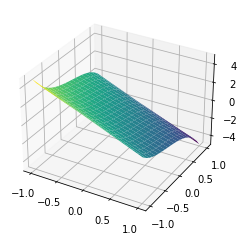

In [137]:
x = np.linspace(-1, 1, 20)
y = np.linspace(-1, 1, 20)
X, Y = np.meshgrid(x, y)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, total_u, cmap='viridis');

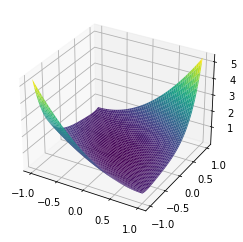

In [138]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)

Z = dataValueFunction( torch.tensor( [X.reshape(-1, 1), Y.reshape(-1, 1)] ).squeeze().float().T ).reshape(-1, 100).T

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis');

## Infer value function from the control

In [186]:
def computeValueFunction(new_barx_i):
    save_barx_i = np.zeros( (100, 2) )
    save_u_i = np.zeros( (100, 1) )
    
    for i, t in enumerate( np.arange(0, T, dt) ):
        save_barx_i[i] = new_barx_i

        # compute the control
        barx_i = new_barx_i
        # gradV = np.array( [v1_deriv(barx_i[0], barx_i[1]), v2_deriv(barx_i[0], barx_i[1])] )
        gradV = np.array( [gradfx(barx_i[0], barx_i[1]), gradfy(barx_i[0], barx_i[1])] )
        baru = - B.T @ gradV
        
        # compute the dynamics
        A = np.array([[0, 1], [barx_i[0]**2, 0]])
        new_barx_i = barx_i + A @ barx_i * dt + B @ baru * dt

        save_u_i[i] = baru.item()
        
    # compute the value function
    v = 0.5 * np.trapz(y=save_barx_i[:, 0]**2, dx=dt) + 0.5 * np.trapz(y=save_barx_i[:, 1]**2, dx=dt) + 0.5 * np.trapz(y=np.squeeze( save_u_i**2 ), dx=dt)

    return v

In [189]:
total_v = np.zeros((100, 100))
for i, x1 in enumerate( np.linspace(-1, 1, 100) ):
    for j, x2 in enumerate( np.linspace(-1, 1, 100) ):
        total_v[i, j] = computeValueFunction( np.array([x1, x2]) )

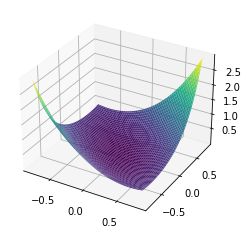

In [188]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, total_v, cmap='viridis');

In [144]:
# infer trajectories and graph_u

gradvy, gradvx = np.gradient( total_v, 2 / 99., 2 / 99. )

In [145]:
from scipy import interpolate
xnode = np.linspace(-1, 1, 100)
x, y = np.meshgrid(xnode, xnode)
interpol_gradvx = interpolate.interp2d(x, y, gradvx)
interpol_gradvy = interpolate.interp2d(x, y, gradvy)

In [146]:
def trajectories_from_value_function():
    resu = {}
    save_u = {}
    for sample in range(n_samples):
        new_barx_i = barx[sample, :]
        save_barx_i = np.zeros( (100, 2) )
        save_u_i = np.zeros( (100, 1) )
        
        for i, t in enumerate( np.arange(0, T, dt) ):
            save_barx_i[i] = new_barx_i

            # compute the control
            barx_i = new_barx_i
            gradV = np.array( [interpol_gradvx(barx_i[0], barx_i[1]).item(), interpol_gradvy(barx_i[0], barx_i[1]).item()] )
            baru = - B.T @ gradV 
            
            # compute the dynamics
            A = np.array([[0, 1], [barx_i[0]**2, 0]])
            new_barx_i = barx_i + A @ barx_i * dt + B @ baru * dt

            save_u_i[i] = baru.item()
            
        resu[sample] = save_barx_i
        save_u[sample] = save_u_i
    return resu, save_u

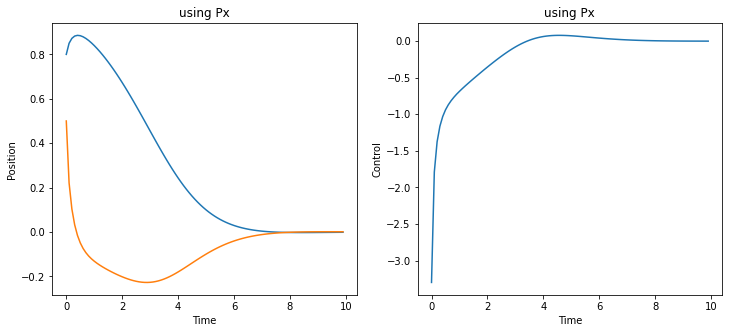

In [148]:
resu, save_u = trajectories_from_value_function()

fig, axs = plt.subplots(1, 2,figsize=(12, 5))
ax = axs[0]
for sample in range(n_samples):
    ax.plot(np.arange(0, T, dt), resu[sample][:, 0])
    ax.plot(np.arange(0, T, dt), resu[sample][:, 1])
ax.set_ylabel('Position')
ax.set_xlabel('Time')
ax.set_title('using Px');

ax = axs[1]
for sample in range(n_samples):
    ax.plot(np.arange(0, T, dt), save_u[sample][:, 0])
ax.set_ylabel('Control')
ax.set_xlabel('Time')
ax.set_title('using Px');

In [181]:
# can we compute back the value function?
# be carefull with the borders

def computeValueFunction(new_barx_i):
    save_barx_i = np.zeros( (100, 2) )
    save_u_i = np.zeros( (100, 1) )
    
    for i, t in enumerate( np.arange(0, T, dt) ):
        save_barx_i[i] = new_barx_i

        # compute the control
        barx_i = new_barx_i
        # gradV = np.array( [v1_deriv(barx_i[0], barx_i[1]), v2_deriv(barx_i[0], barx_i[1])] )
        gradV = np.array( [interpol_gradvx(barx_i[0], barx_i[1]).item(), interpol_gradvy(barx_i[0], barx_i[1]).item()] )
        baru = - B.T @ gradV
        
        # compute the dynamics
        A = np.array([[0, 1], [barx_i[0]**2, 0]])
        new_barx_i = barx_i + A @ barx_i * dt + B @ baru * dt

        save_u_i[i] = baru.item()
        
    # compute the value function
    v = 0.5 * np.trapz(y=save_barx_i[:, 0]**2, dx=dt) + 0.5 * np.trapz(y=save_barx_i[:, 1]**2, dx=dt) + 0.5 * np.trapz(y=np.squeeze( save_u_i**2 ), dx=dt)

    return v

In [184]:
total_v = np.zeros((100, 100))
for i, x1 in enumerate( np.linspace(-0.8, 0.8, 100) ):
    for j, x2 in enumerate( np.linspace(-0.8, 0.8, 100) ):
        total_v[i, j] = computeValueFunction( np.array([x1, x2]) )

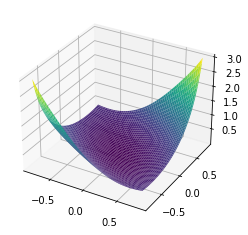

In [185]:
x = np.linspace(-0.8, 0.8, 100)
y = np.linspace(-0.8, 0.8, 100)
X, Y = np.meshgrid(x, y)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, total_v, cmap='viridis');

# Semi Lagrangian

In [43]:
# load exact control and eaxct value function

In [2]:
Z_value = pd.read_csv('non_linear_true_solution/semi_lagrangian/exact_solution.csv', header=None).iloc[50:151, 50:151]

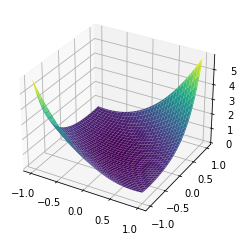

In [3]:
x = np.linspace(-1, 1, 101)
y = np.linspace(-1, 1, 101)
X, Y = np.meshgrid(x, y)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z_value, cmap='viridis');

In [149]:
# we can check the trajectories from the value function

gradvy, gradvx = np.gradient( Z_value, .02, .02 )

In [151]:
from scipy import interpolate
xnode = np.linspace(-1, 1, 101)
x, y = np.meshgrid(xnode, xnode)
interpol_gradvx = interpolate.interp2d(x, y, gradvx)
interpol_gradvy = interpolate.interp2d(x, y, gradvy)

/usr/local/lib/python3.9/site-packages/scipy/interpolate/_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=103,104 m=10201 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


In [152]:
def trajectories_from_value_function():
    resu = {}
    save_u = {}
    for sample in range(n_samples):
        new_barx_i = barx[sample, :]
        save_barx_i = np.zeros( (100, 2) )
        save_u_i = np.zeros( (100, 1) )
        
        for i, t in enumerate( np.arange(0, T, dt) ):
            save_barx_i[i] = new_barx_i

            # compute the control
            barx_i = new_barx_i
            gradV = np.array( [interpol_gradvx(barx_i[0], barx_i[1]).item(), interpol_gradvy(barx_i[0], barx_i[1]).item()] )
            baru = - B.T @ gradV 
            
            # compute the dynamics
            A = np.array([[0, 1], [barx_i[0]**2, 0]])
            new_barx_i = barx_i + A @ barx_i * dt + B @ baru * dt

            save_u_i[i] = baru.item()
            
        resu[sample] = save_barx_i
        save_u[sample] = save_u_i
    return resu, save_u

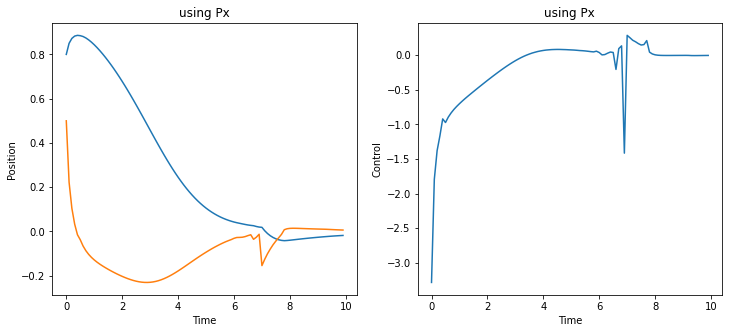

In [153]:
resu, save_u = trajectories_from_value_function()

fig, axs = plt.subplots(1, 2,figsize=(12, 5))
ax = axs[0]
for sample in range(n_samples):
    ax.plot(np.arange(0, T, dt), resu[sample][:, 0])
    ax.plot(np.arange(0, T, dt), resu[sample][:, 1])
ax.set_ylabel('Position')
ax.set_xlabel('Time')
ax.set_title('using Px');

ax = axs[1]
for sample in range(n_samples):
    ax.plot(np.arange(0, T, dt), save_u[sample][:, 0])
ax.set_ylabel('Control')
ax.set_xlabel('Time')
ax.set_title('using Px');

In [3]:
u_control = pd.read_csv('non_linear_true_solution/semi_lagrangian/exact_control.csv', header=None)
u_control_limited = u_control.iloc[50:151, 50:151]

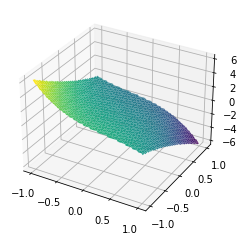

In [18]:
x = np.linspace(-1, 1, 101)
y = np.linspace(-1, 1, 101)
X, Y = np.meshgrid(x, y)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, u_control_limited.T, cmap='viridis');

In [19]:
from scipy import interpolate
xnode = np.linspace(-2, 2, 201)[50:151]
x, y = np.meshgrid(xnode, xnode)
u_control_table = u_control.to_numpy()[50:151, 50:151]
interpol_control_u = interpolate.interp2d(x, y, u_control_table.T)

In [20]:
import scipy.linalg
n_samples = 1
T = 10
dt = 0.1
barx = np.random.random( (n_samples, 2) )
barx = np.array([[0.8, 0.5], [0.3, -0.7]])

B = np.array([[0], [1]])
Q = np.eye(2, 2)
R = np.eye(2, 2)

def trajectories_from_exact_control():
    resu = {}
    save_u = {}
    for sample in range(n_samples):
        new_barx_i = barx[sample, :]
        save_barx_i = np.zeros( (100, 2) )
        save_u_i = np.zeros( (100, 1) )
        
        for i, t in enumerate( np.arange(0, T, dt) ):
            save_barx_i[i] = new_barx_i

            # compute the control
            barx_i = new_barx_i
            baru = interpol_control_u( round(barx_i[0], 4),  round(barx_i[1], 4))

            # compute the dynamics
            A = np.array([[0, 1], [barx_i[0]**2, 0]])
            new_barx_i = barx_i + A @ barx_i * dt + B @ baru * dt

            save_u_i[i] = baru.item()
            
        resu[sample] = save_barx_i
        save_u[sample] = save_u_i
    return resu, save_u

In [32]:
resu, save_u = trajectories_from_exact_control()

In [33]:
resu_sdre, save_u_sdre = compute_trajectories()

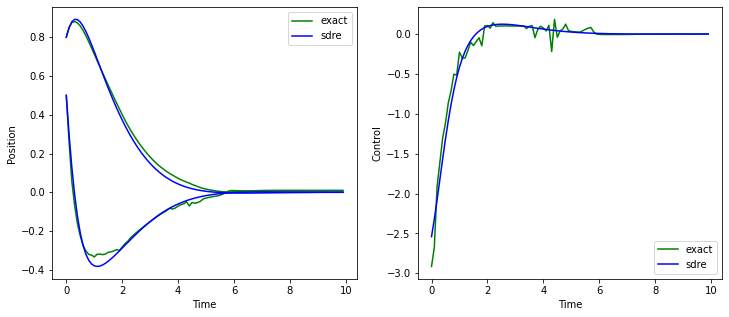

In [43]:
fig, axs = plt.subplots(1, 2,figsize=(12, 5))
ax = axs[0]
for sample in range(n_samples):
    ax.plot(np.arange(0, T, dt), resu[sample][:, 0], color='green', label='exact')
    ax.plot(np.arange(0, T, dt), resu[sample][:, 1], color='green')

    ax.plot(np.arange(0, T, dt), resu_sdre[sample][:, 0], color='blue', label='sdre')
    ax.plot(np.arange(0, T, dt), resu_sdre[sample][:, 1], color='blue')
ax.set_ylabel('Position')
ax.set_xlabel('Time')
ax.legend();

ax = axs[1]
for sample in range(n_samples):
    ax.plot(np.arange(0, T, dt), save_u[sample][:, 0], color='green', label='exact')
    ax.plot(np.arange(0, T, dt), save_u_sdre[sample][:, 0], color='blue', label='sdre')
ax.set_ylabel('Control')
ax.set_xlabel('Time')
ax.legend();

# Neural network

In [107]:
nn_true = pd.read_csv( 'non_linear_true_solution/neural_net/non_linear_true.csv' ).drop(columns=['Unnamed: 0']).to_numpy()

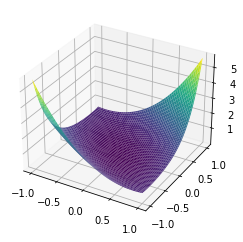

In [109]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, nn_true, cmap='viridis');

In [163]:
# infer trajectories and graph_u

gradvy, gradvx = np.gradient( nn_true, 2./99, 2./99 )

In [164]:
from scipy import interpolate
xnode = np.linspace(-1, 1, 100)
x, y = np.meshgrid(xnode, xnode)
interpol_gradvx = interpolate.interp2d(x, y, gradvx)
interpol_gradvy = interpolate.interp2d(x, y, gradvy)

In [165]:
def trajectories_from_value_function():
    resu = {}
    save_u = {}
    for sample in range(n_samples):
        new_barx_i = barx[sample, :]
        save_barx_i = np.zeros( (100, 2) )
        save_u_i = np.zeros( (100, 1) )
        
        for i, t in enumerate( np.arange(0, T, dt) ):
            save_barx_i[i] = new_barx_i

            # compute the control
            barx_i = new_barx_i
            gradV = np.array( [interpol_gradvx(barx_i[0], barx_i[1]).item(), interpol_gradvy(barx_i[0], barx_i[1]).item()] )
            baru = - B.T @ gradV 
            
            # compute the dynamics
            A = np.array([[0, 1], [barx_i[0]**2, 0]])
            new_barx_i = barx_i + A @ barx_i * dt + B @ baru * dt

            save_u_i[i] = baru.item()
            
        resu[sample] = save_barx_i
        save_u[sample] = save_u_i
    return resu, save_u

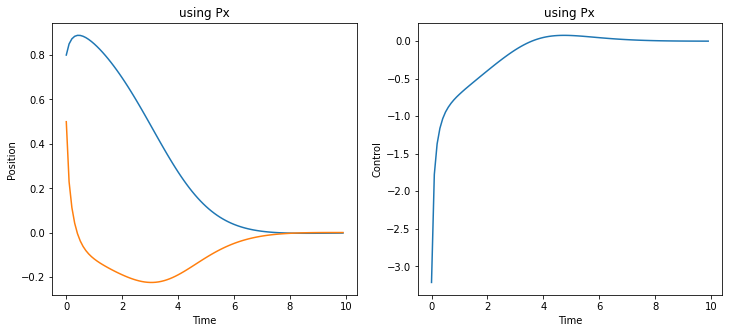

In [166]:
resu, save_u = trajectories_from_value_function()

fig, axs = plt.subplots(1, 2,figsize=(12, 5))
ax = axs[0]
for sample in range(n_samples):
    ax.plot(np.arange(0, T, dt), resu[sample][:, 0])
    ax.plot(np.arange(0, T, dt), resu[sample][:, 1])
ax.set_ylabel('Position')
ax.set_xlabel('Time')
ax.set_title('using Px');

ax = axs[1]
for sample in range(n_samples):
    ax.plot(np.arange(0, T, dt), save_u[sample][:, 0])
ax.set_ylabel('Control')
ax.set_xlabel('Time')
ax.set_title('using Px');

In [172]:
0.5 * np.trapz(y=resu[0][:, 0]**2, dx=dt) + 0.5 * np.trapz(y=resu[0][:, 1]**2, dx=dt) + 0.5 * np.trapz(y=np.squeeze( save_u[sample][:, 0]**2 ), dx=dt)

2.057421551160872